In [1]:
import numpy as np
from random import shuffle
from scipy.stats import entropy
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import nashpy as nash
import random
import time

In [2]:
import open_spiel
import pyspiel

In [3]:
"""
Row player max, col player min
"""

'\nRow player max, col player min\n'

In [4]:
def get_br_to_strat(strat, payoffs, strat_is_row=True, verbose=False):
    if strat_is_row:
        weighted_payouts = strat@payoffs
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
        
        br = np.zeros_like(weighted_payouts)
        br[np.argmin(weighted_payouts)] = 1
        idx = np.argmin(weighted_payouts)
    else:
        weighted_payouts = payoffs@strat.T
        if verbose:
            print("strat ", strat)
            print("weighted payouts ", weighted_payouts)
            
        br = np.zeros_like(weighted_payouts)
        br[np.argmax(weighted_payouts)] = 1
        idx = np.argmax(weighted_payouts)
    return br, idx

In [6]:
def fictitious_play(payoffs, iters=2000, verbose=False):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    col_averages = col_pop
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
        row_average = np.average(row_pop, axis=0)
        col_average = np.average(col_pop, axis=0)
   
        row_br, idx = get_br_to_strat(col_average, payoffs, strat_is_row=False, verbose=False) 
        col_br, idx = get_br_to_strat(row_average, payoffs, strat_is_row=True, verbose=False)
        
        exp1 = row_average@payoffs@col_br.T
        exp2 = row_br@payoffs@col_average.T
        exps.append(exp2-exp1)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)        
        if verbose:
            print(exps[-1], "exploitability")
        
        row_averages = np.vstack((row_averages, row_average))
        col_averages = np.vstack((col_averages, col_average))
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
    return row_averages, col_averages, exps, times 

In [10]:
payoffs = np.array([[2,-3], [-2,1]])
row, col, exps, times = fictitious_play(payoffs, iters=50000)
print(row[-1])
print(col[-1])
print(payoffs)
print(exps[-1])

[0.37446485 0.62553515]
[0.49676069 0.50323931]
[[ 2 -3]
 [-2  1]]
0.011858522085365975


In [6]:
def get_exploitability(row_pop, col_pop, payoffs, iters=1000):
    emp_game_matrix = row_pop@payoffs@col_pop.T
    row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=iters)
    row_strat = row_averages[-1]@row_pop
    col_br, idx = get_br_to_strat(row_strat, payoffs=payoffs, strat_is_row=True)
    col_strat = col_averages[-1]@col_pop
    row_br, idx = get_br_to_strat(col_strat, payoffs=payoffs, strat_is_row=False)
    exp1 = row_strat@payoffs@col_br.T
    exp2 = row_br@payoffs@col_strat
    return exp2 - exp1

In [71]:
def double_oracle(payoffs, iters=100, custom_row_strat=np.array([0]), custom_col_strat=np.array([0])):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    if custom_row_strat.any():
        row_pop = custom_row_strat
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    if custom_col_strat.any():
        col_pop = custom_col_strat
    col_averages = col_pop
    row_indices = []
    col_indices = []
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
#         print("Iteration: ", i+1)
        emp_game_matrix = row_pop@payoffs@col_pop.T
        row_averages, col_averages, _, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
        row_strat = row_averages[-1]@row_pop
        col_strat = col_averages[-1]@col_pop
        
        row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False) 
        col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False)
        
#         print("Row Index: ", row_idx+1)
#         print("Column Index: ", col_idx+1)
        
        if row_idx in row_indices and col_idx in col_indices:
#             print(row_indices, col_indices)
            print('num iters do: ', i)
            return row_pop, col_pop, row_averages, col_averages, exps, times
        row_indices.append(row_idx)
        col_indices.append(col_idx)
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
        
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        exp = get_exploitability(row_pop, col_pop, payoffs)
        exps.append(exp)

    return row_pop, col_pop, row_strat, col_strat, exps, times      


In [72]:
def rm_double_oracle(payoffs, iters=100, custom_row_strat=np.array([0]), custom_col_strat=np.array([0])):
    row_dim = payoffs.shape[0]
    col_dim = payoffs.shape[1]
    row_pop = np.random.uniform(0,1,(1, row_dim))
    row_pop = row_pop/row_pop.sum(axis=1)[:,None]
    if custom_row_strat.any():
        row_pop = custom_row_strat
    row_averages = row_pop
    col_pop = np.random.uniform(0,1,(1, col_dim))
    col_pop = col_pop/col_pop.sum(axis=1)[:,None]
    if custom_col_strat.any():
        col_pop = custom_col_strat
    col_averages = col_pop
    row_indices = []
    col_indices = []
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
#         print("Iteration: ", i+1)
        emp_game_matrix = row_pop@payoffs@col_pop.T
        row_pop_rm, col_pop_rm, _, _, _, _ = regret_matching(payoffs=emp_game_matrix, iters=1000)
#         row_averages, col_averages, _ = fictitious_play(payoffs=emp_game_matrix, iters=1000)
        row_strat = row_pop_rm[-1]@row_pop
        col_strat = col_pop_rm[-1]@col_pop
        
        row_br, row_idx = get_br_to_strat(col_strat, payoffs, strat_is_row=False, verbose=False) 
        col_br, col_idx = get_br_to_strat(row_strat, payoffs, strat_is_row=True, verbose=False)
        
#         print("Row Index: ", row_idx+1)
#         print("Column Index: ", col_idx+1)
        
        if row_idx in row_indices and col_idx in col_indices:
            print('num iters rm-do: ', i)
#             print(row_indices, col_indices)
            return row_pop, col_pop, row_averages, col_averages, exps, times
        row_indices.append(row_idx)
        col_indices.append(col_idx)
        
        row_pop = np.vstack((row_pop, row_br))
        col_pop = np.vstack((col_pop, col_br))
        
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)

        exp = get_exploitability(row_pop, col_pop, payoffs)
        exps.append(exp)

    return row_pop, col_pop, row_strat, col_strat, exps, times    

In [62]:
"""
1. what if one player doesn't sample actions, or uses the same action?
    doesn't work (revisit folk theorem)
2. what if we don't subtract payoff (get all negative cumulative regrets (why?))
3. what are ending cumulative regrets
"""

"\n1. what if one player doesn't sample actions, or uses the same action?\n    doesn't work (revisit folk theorem)\n2. what if we don't subtract payoff (get all negative cumulative regrets (why?))\n3. what are ending cumulative regrets\n"

In [63]:
def regret_matching(payoffs, iters=5000, plus=False):
    cumulative_row_regrets = np.ones(payoffs.shape[0])
    cumulative_col_regrets = np.ones(payoffs.shape[1])
    row_pop = cumulative_row_regrets/cumulative_row_regrets.sum()
    col_pop = cumulative_col_regrets/cumulative_col_regrets.sum()
    cumulative_norm_positive_row_regrets = row_pop
    cumulative_norm_positive_col_regrets = col_pop
    start_time = time.time()
    times = []
    exps = []
    for i in range(iters):
        norm_positive_row_regrets = cumulative_row_regrets.clip(min=0)/cumulative_row_regrets.clip(min=0).sum()
        norm_positive_col_regrets = cumulative_col_regrets.clip(min=0)/cumulative_col_regrets.clip(min=0).sum()
        
        row_action = np.random.multinomial(1, norm_positive_row_regrets)
        col_action = np.random.multinomial(1, norm_positive_col_regrets)
        
        payoff = row_action@payoffs@col_action
        row_regrets = np.identity(payoffs.shape[0])@payoffs@col_action - payoff
        col_regrets = payoff - row_action@payoffs@np.identity(payoffs.shape[1])
               
        cumulative_row_regrets += row_regrets
        cumulative_col_regrets += col_regrets
        if plus:
            cumulative_row_regrets = cumulative_row_regrets.clip(min=0)
            cumulative_col_regrets = cumulative_col_regrets.clip(min=0)
        
        #keep track of average strategy, measure exploitability
        cumulative_norm_positive_row_regrets += norm_positive_row_regrets
        cumulative_norm_positive_col_regrets += norm_positive_col_regrets
        row_strat = cumulative_norm_positive_row_regrets/cumulative_norm_positive_row_regrets.sum()
        col_strat = cumulative_norm_positive_col_regrets/cumulative_norm_positive_col_regrets.sum()
        col_br, _ = get_br_to_strat(row_strat, payoffs)
        row_br, _ = get_br_to_strat(col_strat, payoffs, strat_is_row=False)
        exp1 = row_strat@payoffs@col_br
        exp2 = row_br@payoffs@col_strat
        exp = exp2 - exp1
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        exps.append(exp)
        row_pop = np.vstack((row_pop, row_strat))
        col_pop = np.vstack((col_pop, col_strat))
    
    return row_pop, col_pop, cumulative_norm_positive_row_regrets, cumulative_norm_positive_col_regrets, exps, times

In [96]:
dim = 150
payoffs = np.tril(np.random.uniform(-1, 1, (dim,dim)), -1)
payoffs = (payoffs - payoffs.T)

In [88]:
def get_pure_strat_payoffs(num_strats):
    dummy_game_matrix = np.zeros((num_strats, num_strats))
    for i in range(num_strats):
        for j in range(num_strats):
            dummy_game_matrix[i, j] = i-j
    payoffs = dummy_game_matrix
    return payoffs

In [89]:
payoffs100 = get_pure_strat_payoffs(100)
payoffs250 = get_pure_strat_payoffs(250)
payoffs1000 = get_pure_strat_payoffs(1000)

In [68]:
num_strats = 5
payoffs = np.ones((num_strats, num_strats))
rps = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]])
for i in range(3):
    for j in range(3):
        payoffs[i, j] = rps[i, j]
print(payoffs)

[[ 0. -1.  1.  1.  1.]
 [ 1.  0. -1.  1.  1.]
 [-1.  1.  0.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]


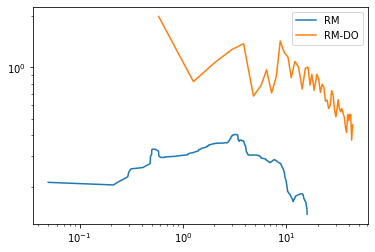

In [101]:
# payoffs = np.array([[0, -1, 1], [1, 0, -1]])
iters = 1000
# row_averages, col_averages, exps, times = fictitious_play(payoffs, iters=iters)
# row_pop, col_pop, _, _, rm_exps, rm_times = regret_matching(payoffs, iters=iters)
# # row_pop, col_pop, cumulative_avg_row_regrets, cumulative_avg_col_regrets, rm_plus_exps = regret_matching(payoffs, iters=iters, plus=True)
# # row_pop, col_pop, row_strat, col_strat, do_exps, do_times = double_oracle(payoffs, iters=50)
# rm_row_pop, rm_col_pop, _, _, rm_do_exps, rm_do_times = rm_double_oracle(payoffs, iters=50)

_, _, _, _, rm_exps, rm_times = regret_matching(payoffs, iters=iters)
_, _, _, _, rm_do_exps, rm_do_times = rm_double_oracle(payoffs, iters=50)


# _, _, _, _, rm_exps100, rm_times100 = regret_matching(payoffs100, iters=iters)
# _, _, _, _, rm_do_exps100, rm_do_times100 = rm_double_oracle(payoffs100, iters=50)
# _, _, _, _, rm_exps250, rm_times250 = regret_matching(payoffs250, iters=iters)
# _, _, _, _, rm_do_exps250, rm_do_times250 = rm_double_oracle(payoffs250, iters=50)
# _, _, _, _, rm_exps1000, rm_times1000 = regret_matching(payoffs1000, iters=iters)
# _, _, _, _, rm_do_exps1000, rm_do_times1000 = rm_double_oracle(payoffs1000, iters=50)


# plt.plot(times, exps, label='FP')
# plt.plot(rm_times, rm_exps, label='RM')
# # plt.plot(rm_plus_exps, label='RM+')
# plt.plot(rm_do_times, rm_do_exps, label='RM-DO')
# plt.plot(do_times, do_exps, label='DO')

plt.plot(rm_times, rm_exps, label='RM')
plt.plot(rm_do_times, rm_do_exps, label='RM-DO')

# plt.plot(rm_times250, rm_exps250, label='RM-250')
# plt.plot(rm_do_times250, rm_do_exps250, label='RM-DO-250')

# plt.plot(rm_times1000, rm_exps1000, label='RM-1000')
# plt.plot(rm_do_times1000, rm_do_exps1000, label='RM-DO-1000')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.show()
# print(row_averages[-1])
# print(col_averages[-1])
# print(row_pop[-1])
# print(col_pop[-1])
# print(cumulative_avg_row_regrets)
# print(cumulative_avg_col_regrets)

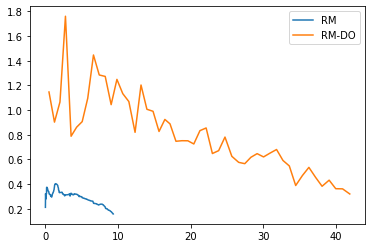

In [100]:
plt.plot(rm_times, rm_exps, label='RM')
plt.plot(rm_do_times, rm_do_exps, label='RM-DO')

# plt.plot(rm_times250, rm_exps250, label='RM-250')
# plt.plot(rm_do_times250, rm_do_exps250, label='RM-DO-250')

# plt.plot(rm_times1000, rm_exps1000, label='RM-1000')
# plt.plot(rm_do_times1000, rm_do_exps1000, label='RM-DO-1000')

plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.show()

In [74]:
print(rm_do_exps)
print(do_exps)
print(rm_do_times)

[0.09122280359276802]
[0.10267531473015332]
[0.5479512214660645]


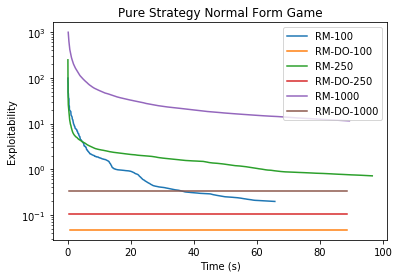

In [95]:
plt.plot(rm_times100, rm_exps100, label='RM-100')
plt.plot([rm_do_times100[0]+i for i in range(int(max(rm_times1000)))], [rm_do_exps100[-1] for i in range(int(max(rm_times1000)))], label='RM-DO-100')

plt.plot(rm_times250, rm_exps250, label='RM-250')
plt.plot([rm_do_times250[0]+i for i in range(int(max(rm_times1000)))], [rm_do_exps250[-1] for i in range(int(max(rm_times1000)))], label='RM-DO-250')

plt.plot(rm_times1000, rm_exps1000, label='RM-1000')
plt.plot([rm_do_times1000[0]+i for i in range(int(max(rm_times1000)))], [rm_do_exps1000[-1] for i in range(int(max(rm_times1000)))], label='RM-DO-1000')
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Exploitability')
plt.xlabel('Time (s)')
plt.title('Pure Strategy Normal Form Game')
plt.show()


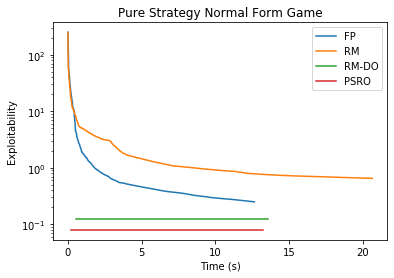

In [87]:
# plt.plot(times, exps, label='FP')
plt.plot(rm_times, rm_exps, label='RM')
# plt.plot(rm_plus_exps, label='RM+')
# plt.plot(rm_do_times, rm_do_exps, label='RM-DO')
plt.plot([rm_do_times[0]+i for i in range(14)], [rm_do_exps[-1] for i in range(14)], label='RM-DO')
# plt.plot([do_times[0]+i for i in range(14)], [do_exps[-1] for i in range(14)], label='PSRO')

# plt.plot(do_times, do_exps, label='FP-DO')
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Exploitability')
plt.xlabel('Time (s)')
plt.title('Pure Strategy Normal Form Game')
plt.show()


In [40]:
rm_do_exps

[23.605348076158066,
 16.04418923880659,
 12.033141929104943,
 9.626513543283956,
 8.022094619403296,
 6.876081102345681,
 6.016570964552471,
 5.348063079602197,
 4.813256771641978,
 4.3756879742199795,
 4.011047309701648,
 3.7025052089553676,
 3.4380405511728407,
 3.208837847761318,
 3.0082854822762357,
 2.8313275127305753,
 2.6740315398010983,
 2.533293037706304,
 2.406628385820989,
 2.292027034115227,
 2.1878439871099897,
 2.0927203354965123,
 2.005523654850824,
 1.925302708656791,
 1.8512526044776838,
 1.7826876932007325,
 1.7190202755864203,
 1.6597437143593026,
 1.604418923880659,
 1.5526634747232184,
 1.5041427411381179,
 1.4585626580733266,
 1.4156637563652876,
 1.3752162204691363,
 1.3370157699005492,
 1.3008802085518858,
 1.266646518853152,
 1.2341684029851225,
 1.2033141929104945,
 1.1739650662541408,
 1.1460135170576136,
 1.119362039916739,
 1.0939219935549949,
 1.0696126159204395,
 1.0463601677482561,
 1.02409718545574,
 1.002761827425412,
 0.9822973003350974,
 0.962651354

In [ ]:
payoffs = np.array([[-1,-2], [-1,-2], [-1,1], [-1,1], [2, -2], [2, -2], [2, 1], [2, 1], 
                    [-2, 1], [-1, 2], [-2, 1], [-1, 2], [-2, 1], [-1, 2], [-2, 1], [-1, 2]])

custom_row_strat = np.zeros((1, payoffs.shape[0]))
custom_row_strat[0, 0] = 1
custom_col_strat = np.zeros((1, payoffs.shape[1]))
custom_col_strat[0, 0] = 1
print(custom_col_strat)
print(custom_row_strat)

row_pop, col_pop, row_strat, col_strat, exps = double_oracle(payoffs, 
                                                             custom_row_strat=custom_row_strat, 
                                                             custom_col_strat=custom_col_strat)
plt.plot(exps)
plt.show()
print(row_averages[-1])
print(col_averages[-1])

In [ ]:

row_averages, col_averages, exps = fictitious_play(payoffs, iters=5000)
plt.plot(exps)
plt.show()
print(row_averages[-1])
print(col_averages[-1])